# Imports

In [116]:
# All imports


# General
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# For CNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For handling Images
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

# Tensorflow
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'1.14.0'

# Data Loading

In [ ]:
# unzipping files

import zipfile
with zipfile.ZipFile('./trafficsigns_shapedata.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [117]:
# Loading image path and labels
image_list = []
for filepath in glob.glob('./trafficsigns_shapedata/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
ShapeImagedata = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

# Inspecting Data

In [118]:
ShapeImagedata.head()

,image_path,label
0,./trafficsigns_shapedata/square/00290_00001.png,square
1,./trafficsigns_shapedata/square/01577_00000.png,square
2,./trafficsigns_shapedata/square/01366_00000.png,square
3,./trafficsigns_shapedata/square/00482_00000.png,square
4,./trafficsigns_shapedata/square/01731_00000.png,square


In [119]:
print(ShapeImagedata.shape)
ShapeImagedata.label.unique()

(3650, 2)


array(['square', 'diamond', 'hex', 'triangle', 'round'], dtype=object)

Data contains two columns, having location of image and its corresponding label. We have a total of 5 label classes from which we need to classify. our total dataset contains 3650 images

In [120]:
ShapeImagedata.groupby(['label']).count()

,image_path
label,
diamond,282
hex,43
round,1711
square,688
triangle,926


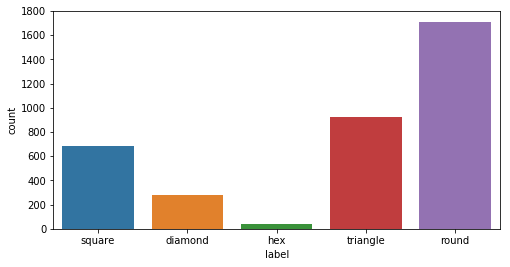

In [121]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=ShapeImagedata);# unbalanced classes

We can see from above visualisation that classes are unbalanced

# Display images

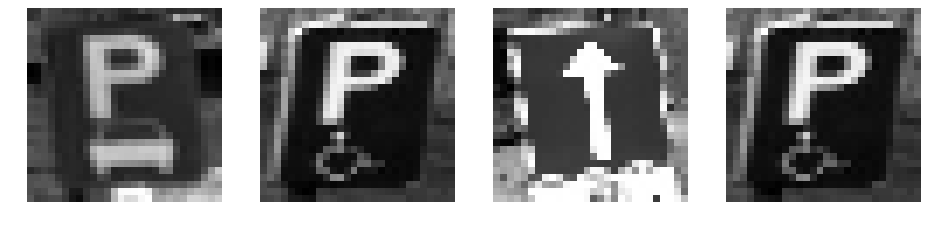

In [122]:
# displaying random images

r_inx = np.random.choice(100, 4)
rand_data = ShapeImagedata.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

# Some other utility functions

In [123]:
def flatten(data):   
    l = []
    for i in range(len(data)):
        x = Image.open(data.iloc[i][0])
        x = np.array(x)
        l.append(x.flatten())
    return pd.DataFrame(np.array(l))

In [124]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res.history['loss'])
    plt.plot(res.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(res.history['categorical_accuracy'])
    plt.plot(res.history['val_categorical_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

# Label mapping 

- this mapping is used across all models (not required for random forest or SVM though) 

In [125]:
#label mapping
d = {'square':0, 'diamond':1, 'hex':2, 'triangle':3, 'round':4}
ShapeImagedata['labels_num'] = ShapeImagedata['label'].map(d, na_action='ignore')

# Image Classification using Random Forest

Will First start with traditional pure machine learning models

### Data Preprocessing  

- Splitting independent variables from the dependent variable in both training and testing

In [137]:
XData = ShapeImagedata.iloc[:,0:1]
YData = ShapeImagedata.labels_num

- Flattening the data

In [138]:
XData = flatten(XData)

- splitting total data into 80% training and 20% validation

In [139]:
x_train, x_test, y_train_v, y_test_v = train_test_split(XData, YData, test_size = 0.2, random_state = 2)

In [140]:
y_train_v =np.array(y_train_v) # converting to array

### Model Creation and training

In [130]:
rf = RandomForestClassifier(n_estimators=10)

In [131]:
rf.fit(x_train,y_train_v)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### prediction

In [132]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

In [133]:
print("Training Accuracy : ", accuracy_score(y_true= y_train_v, y_pred= y_pred_train))
print("Validation Accuracy : ", accuracy_score(y_true= y_test_v, y_pred= y_pred_test))

Training Accuracy :  1.0
Validation Accuracy :  0.9356164383561644


In [134]:
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))

print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))

Training metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00       761
           4       1.00      1.00      1.00      1351

   micro avg       1.00      1.00      1.00      2920
   macro avg       1.00      1.00      1.00      2920
weighted avg       1.00      1.00      1.00      2920

Test data metrics:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       143
           1       1.00      0.74      0.85        57
           2       0.50      0.20      0.29         5
           3       0.94      0.95      0.94       165
           4       0.91      0.98      0.94       360

   micro avg       0.94      0.94      0.94       730
   macro avg       0.87      0.76      0.79       730
weighted avg       0.94      0.94      0

### Grid Search with cross valdiation to tune hyper parameters

Grid search is required to find the optimized hyperparameters for our data set

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 50],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [2, 4 ,6, 8],
    'n_estimators': [20, 30, 50, 100]
}

In [ ]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(x_train,y_train_v)

In [ ]:
grid_search.best_params_

### Training optimized model using best parameters

In [141]:
rf = RandomForestClassifier(bootstrap=True, max_depth=30, max_features=5,
                            min_samples_leaf=2, min_samples_split=4,n_estimators=100)                                                

In [142]:
rf.fit(x_train,y_train_v)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [143]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

In [146]:
print("Training Accuracy : ", accuracy_score(y_true= y_train_v, y_pred= y_pred_train))
print("Validation Accuracy : ", accuracy_score(y_true= y_test_v, y_pred= y_pred_test))

Training Accuracy :  0.9993150684931507
Validation Accuracy :  0.9534246575342465


In [147]:
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))

print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))

Training metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       225
           2       1.00      0.97      0.99        38
           3       1.00      1.00      1.00       761
           4       1.00      1.00      1.00      1351

   micro avg       1.00      1.00      1.00      2920
   macro avg       1.00      0.99      1.00      2920
weighted avg       1.00      1.00      1.00      2920

Test data metrics:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       143
           1       1.00      0.74      0.85        57
           2       0.00      0.00      0.00         5
           3       0.95      0.98      0.96       165
           4       0.93      0.99      0.96       360

   micro avg       0.95      0.95      0.95       730
   macro avg       0.78      0.73      0.75       730
weighted avg       0.95      0.95      0

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Image classification using SVM (Support Vector Machine)

- We are going to be implementing kernel SVM 

### Data Preprocessing  

- Splitting independent variables from the dependent variable in both training and testing

In [148]:
XData = ShapeImagedata.iloc[:,0:1]
YData = ShapeImagedata.labels_num

- Flattening the data

In [149]:
XData = flatten(XData)

- splitting total data into 80% training and 20% validation

In [150]:
x_train, x_test, y_train_v, y_test_v = train_test_split(XData, YData, test_size = 0.2, random_state = 2)

In [151]:
y_train_v =np.array(y_train_v) # converting to array

### Model Creation and Prediction

In [152]:
svclassifier = SVC(kernel='poly', degree=2, gamma='auto')
svclassifier.fit(x_train,y_train_v)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [153]:
y_pred_train = svclassifier.predict(x_train)
y_pred_test = svclassifier.predict(x_test)

In [154]:
print("Training Accuracy : ", accuracy_score(y_true= y_train_v, y_pred= y_pred_train))
print("Validation Accuracy : ", accuracy_score(y_true= y_test_v, y_pred= y_pred_test))

Training Accuracy :  1.0
Validation Accuracy :  0.958904109589041


In [155]:
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))

print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))

Training metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00       761
           4       1.00      1.00      1.00      1351

   micro avg       1.00      1.00      1.00      2920
   macro avg       1.00      1.00      1.00      2920
weighted avg       1.00      1.00      1.00      2920

Test data metrics:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       143
           1       0.87      0.91      0.89        57
           2       1.00      0.80      0.89         5
           3       0.94      0.97      0.95       165
           4       0.98      0.96      0.97       360

   micro avg       0.96      0.96      0.96       730
   macro avg       0.95      0.92      0.93       730
weighted avg       0.96      0.96      0

# Image classification using Convolutional Neural Network

Its time for neural network now (saved the best for the last) as they are proved to perform exceptionally well on image classification problems

### Train Test split

- splitting total data into 80% training and 20% validation

In [156]:
#generating training, testing and validation sets
trainData, testData = train_test_split(ShapeImagedata ,test_size=0.20, random_state=42)

In [157]:
N_train_images = trainData.shape[0]
N_test_images = testData.shape[0]

### Image Data Generators 

- to augment the image and load into batches to increase computational efficiency

In [158]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

batch_size_t = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)


Found 2920 validated image filenames belonging to 5 classes.
Found 730 validated image filenames belonging to 5 classes.


In [159]:
# Class weights as the classes are unbalanced
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

### Design model

- starting with the most basic model (model version 1)

In [15]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 27045     
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Tota

In [18]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=test_generator, epochs=20)

Epoch 1/20
183/183 [==============================] - 4s 23ms/step - loss: 1.2305 - categorical_accuracy: 0.5058 - val_loss: 0.9851 - val_categorical_accuracy: 0.5932
Epoch 2/20
183/183 [==============================] - 4s 21ms/step - loss: 1.0279 - categorical_accuracy: 0.6099 - val_loss: 0.9528 - val_categorical_accuracy: 0.6425
Epoch 3/20
183/183 [==============================] - 4s 21ms/step - loss: 0.9256 - categorical_accuracy: 0.6582 - val_loss: 0.6887 - val_categorical_accuracy: 0.7151
Epoch 4/20
183/183 [==============================] - 4s 22ms/step - loss: 0.8302 - categorical_accuracy: 0.6918 - val_loss: 0.5869 - val_categorical_accuracy: 0.7575
Epoch 5/20
183/183 [==============================] - 4s 21ms/step - loss: 0.7707 - categorical_accuracy: 0.7182 - val_loss: 0.7291 - val_categorical_accuracy: 0.7082
Epoch 6/20
183/183 [==============================] - 4s 21ms/step - loss: 0.7189 - categorical_accuracy: 0.7377 - val_loss: 0.4145 - val_categorical_accuracy: 0.850

In [17]:
plot_results(res)

NameError: name 'res' is not defined

In [ ]:
model_cnn.evaluate(test_generator)

### Model version 2

- Increasing the complexity of model by adding more layers (model version 2 of CNN)

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3)))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

In [ ]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=20)

In [ ]:
plot_results(res)

In [ ]:
model_cnn.evaluate(test_generator)

### Model Version 3 (FINAL)

- now since we have found a complex enough model now its time to incorporate regularisation, drop out and class weights

In [160]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_9 (Activation)    (None, 9, 9, 64)         

In [161]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=test_generator,class_weight=class_weights, epochs=25)

Epoch 1/25
183/183 [==============================] - 5s 30ms/step - loss: 1.3555 - categorical_accuracy: 0.4606 - val_loss: 1.2833 - val_categorical_accuracy: 0.4384
Epoch 2/25
183/183 [==============================] - 5s 27ms/step - loss: 1.2122 - categorical_accuracy: 0.5236 - val_loss: 0.9107 - val_categorical_accuracy: 0.6671
Epoch 3/25
183/183 [==============================] - 5s 27ms/step - loss: 0.9893 - categorical_accuracy: 0.6370 - val_loss: 0.6216 - val_categorical_accuracy: 0.8055
Epoch 4/25
183/183 [==============================] - 5s 27ms/step - loss: 0.8663 - categorical_accuracy: 0.6914 - val_loss: 0.4542 - val_categorical_accuracy: 0.8534
Epoch 5/25
183/183 [==============================] - 5s 27ms/step - loss: 0.7683 - categorical_accuracy: 0.7250 - val_loss: 0.3338 - val_categorical_accuracy: 0.9151
Epoch 6/25
183/183 [==============================] - 5s 27ms/step - loss: 0.6357 - categorical_accuracy: 0.7836 - val_loss: 0.2628 - val_categorical_accuracy: 0.937

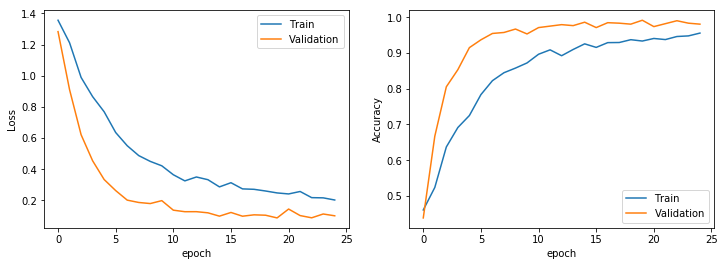

In [162]:
plot_results(res)

In [163]:
model_cnn.evaluate(test_generator)

730/730 [==============================] - 1s 2ms/step - loss: 0.1009 - categorical_accuracy: 0.9808


[0.10094144123874299, 0.9808219]

# Independent evaluation

- The purpose of this is to test our best performing model on real world examples that were not used in training to realise whether if we can implement our current model in the real world environment or not

In [ ]:
# unzipping files

import zipfile
with zipfile.ZipFile('./testdataapna.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
# Loading image path and labels
image_list = []
for filepath in glob.glob('./testdataapna/*/*.jpg', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
IndTestData = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

In [ ]:
TestData.shape

In [ ]:
Independent_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
Independent_test_generator = Independent_test_datagen.flow_from_dataframe(
        dataframe=IndTestData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)



In [ ]:
labels = (Independent_test_generator.class_indices)

d_inv = {v: k for k, v in labels.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in Independent_test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        print(y_hat)
        print(y)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [ ]:
model_cnn.evaluate(Independent_test_generator)